# Data Visualization

### Imports

In [1]:
import os
import json
import pandas as pd

import analysis_utils as utils

Load data from all `../res` sub-directories (treatments):

In [2]:
summary_dfs = {}    # dict to store statistical summary data (<session_name>.json)
all_data_dfs = {}   # dict to store all individual measurements (all_data_<session_name>.json)

experiment_data_dir = '../res' # directory generated by "eval.py", contains the .json files with the experiment data

iteration_structure = True # flag to set the directory structure of the input data

# Load all the experiment data
summary_dfs, all_data_dfs = utils.load_experiment_data(experiment_data_dir, iteration_structure)


Print the loaded dataframes:

In [3]:
#print(summary_dfs["MIS_AWQ_ENCO"])
print(all_data_dfs["MIS_AWQ_ENCO"])

                                   data_path  prevalence     n  tp    tn  fp  \
0  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/01    0.028049  1640  35  1592   2   
1  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/02    0.028049  1640  35  1592   2   
2  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/03    0.028049  1640  35  1592   2   
3  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/04    0.028049  1640  35  1592   2   
4  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/05    0.028049  1640  34  1592   2   
5  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/06    0.028049  1640  34  1592   2   
6  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/07    0.028049  1640  34  1591   3   
7  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/08    0.028049  1640  35  1592   2   
8  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/09    0.028049  1640  35  1592   2   
9  ./out/MIS_AWQ_ENCO/2025-04-28/23_11_13/10    0.028049  1640  34  1592   2   

   fn  accuracy  balanced_accuracy        f1   recall  precision  specificity  \
0  11  0.992073           0.969542  0.

---

## Plots, Tables, Graphs

#### **TODO** - the functions in this section are the first drafts. We need to decide on what we want and implement it.
- improve existing function or add new ones

#### Create MVP table
**Table Structure Example**:

| treatment     | accuracy      | recall | ...  |
|---------------|---------------|--------|------|
| Ollama-None   | (mean ± sd)   |        |      |
| Ollama-Q1     |               |        |      |
| Ollama-Q2     |               |        |      |
| Mixtral-None  |               |        |      |
| Mixtral-Q1    |               |        |      |
| ...           |               |        |      |

**Note**: *treatments* are derived from the session names (keys)

In [4]:
def format_mean_sd(mean, sd):
    """
    Formats mean and standard deviation as a string, 
    rounds to two decimal places and removes trailing zeros.

    Example: "3.1 ± 0.2"
    """
    # Note: values are converted to floats to we don't risk creating empty strings
    mean_str = f"{mean:.2f}".rstrip("0").rstrip(".")
    sd_str = f"{sd:.2f}".rstrip("0").rstrip(".")

    return f"{mean_str} ± {sd_str}"


def create_mvp_table_df(summary_dataframes: dict[str: pd.DataFrame]):
    """
    Creates a table with treatments as rows and metrics as columns,
    showing values as (mean +- standard deviation).
    """

    # Make a temporary copy so we don't modify the original data
    temp_dfs = summary_dataframes.copy()

    # Construct new dataframe with the treatment column populated with the session keys
    treatment_df = pd.DataFrame({"treatment": [key for key in temp_dfs]})
    
    # Dynamically constructs an empty dataframe with the metrics values as column names
    # Each row will hold the data of a session (treatment)
    metrics_df = pd.DataFrame(
            columns=[metrics for metrics in temp_dfs[next(iter(temp_dfs))]["metric"]]
        )
    
    # Iterate over each session key, construct new row with (mean ± sd) values for each metric
    # Note: concatenating dfs in a loop is technically inefficient (could construct using lists)
    #       but we will not have enough treatments for it to really matter.
    for session_key in temp_dfs:
        # Combine columns to create String representations of: mean ± standard deviation
        mean_and_sd = temp_dfs[session_key].apply(
                lambda row: format_mean_sd(row["mean"], row["sd"]), axis=1
            )

        # Convert series to dataframe so we can transpose from column to row
        mean_and_sd_df = mean_and_sd.to_frame().T

        # Copy the column names for easy concatenation
        mean_and_sd_df.columns = metrics_df.columns

        # Add the row to the metrics dataframe
        metrics_df = pd.concat([metrics_df, mean_and_sd_df], ignore_index=True)

    # Concatenate the treatment and metrics dataframes to create the final table
    combined_table_df = pd.concat([treatment_df, metrics_df], axis=1) # concatenates horizontally

    return combined_table_df
            

In [5]:
table_df = create_mvp_table_df(summary_dfs)

print(table_df)

        treatment     all_n       all_tp        all_tn     all_fp  \
0    MIS_AWQ_BTHS   120 ± 0   1.7 ± 0.46       100 ± 0      0 ± 0   
1    MIS_AWQ_ENCO  1640 ± 0  34.6 ± 0.49  1591.9 ± 0.3  2.1 ± 0.3   
2   MIS_AWQ_SNAKE   132 ± 0       10 ± 0       120 ± 0      2 ± 0   
3   MIS_NONE_BTHS   120 ± 0   3.2 ± 0.98       100 ± 0      0 ± 0   
4   MIS_NONE_ENCO  1640 ± 0       35 ± 0      1593 ± 0      1 ± 0   
5  MIS_NONE_SNAKE   132 ± 0       10 ± 0       119 ± 0      3 ± 0   

        all_fn all_accuracy all_balanced_accuracy       all_f1   all_recall  \
0  18.3 ± 0.46     0.85 ± 0              0.92 ± 0  0.16 ± 0.04  0.08 ± 0.02   
1  11.4 ± 0.49     0.99 ± 0              0.97 ± 0  0.84 ± 0.01  0.75 ± 0.01   
2        0 ± 0     0.98 ± 0              0.92 ± 0     0.91 ± 0        1 ± 0   
3  16.8 ± 0.98  0.86 ± 0.01              0.93 ± 0  0.27 ± 0.07  0.16 ± 0.05   
4       11 ± 0     0.99 ± 0              0.98 ± 0     0.85 ± 0     0.76 ± 0   
5        0 ± 0     0.98 ± 0              0

**Plot MVP table [WIP]**

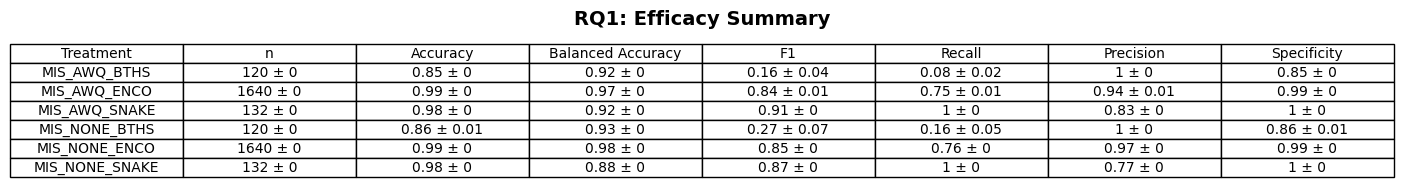

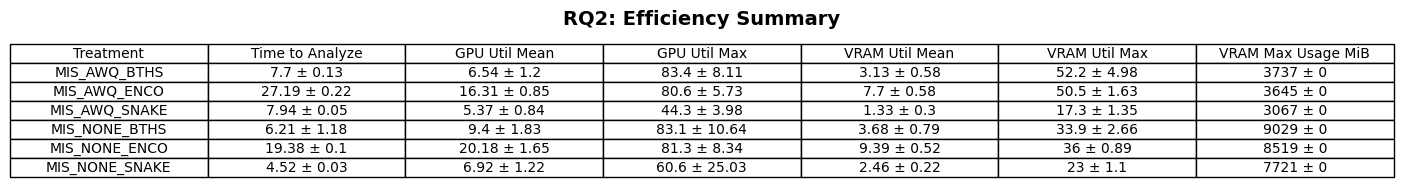

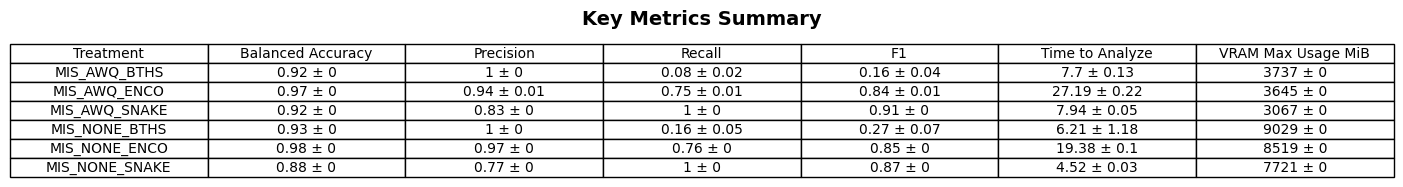

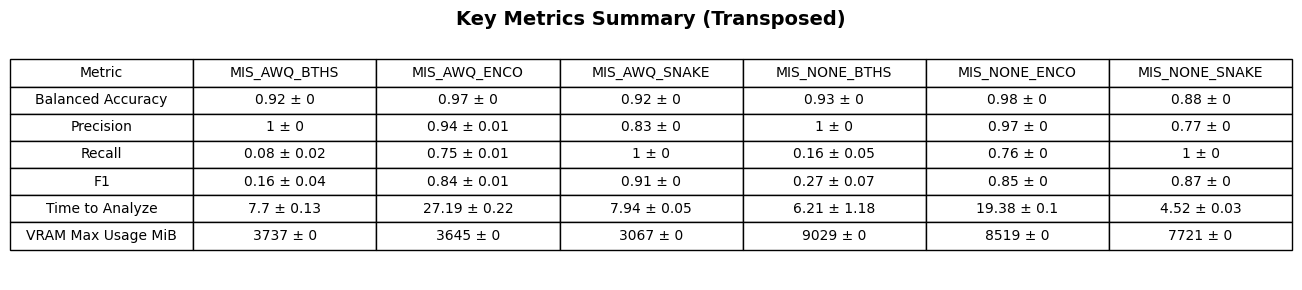

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def prettify_col(col):
    """
    Clean up and prettify the column names.
    """
    col = col.replace("all_", "").replace("_", " ")
    words = col.split()
    return " ".join( # inserts a space character between concatenated strings
        (
            w.upper() if w.lower() in {"tp", "tn", "fp", "fn", "f1", "gpu", "vram"} # all caps for acronyms
            else "MiB" if w.lower() == "mib" # MiB needs special capitalization
            else w if w.lower() in {"n", "to"} # lowercase for sample size and "to" in "Time-to-Analyze"
            else w.title() # title capitalization if multi-word
        )
        for w in words
    )

def plot_table(df, title, figsize=(14, 2), title_pad=20):
    _, ax = plt.subplots(figsize=figsize)
    ax.axis("off")
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     loc="center",
                     cellLoc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.title(title, fontsize=14, fontweight="bold", pad=title_pad)
    plt.tight_layout()
    plt.show()

# "TP", "TN", "FP", "FN",
efficacy_cols = ["Treatment", "n", "Accuracy", "Balanced Accuracy", "F1", "Recall", "Precision", "Specificity"]
efficiency_cols = ["Treatment", "Time to Analyze", "GPU Util Mean", "GPU Util Max", "VRAM Util Mean", "VRAM Util Max", "VRAM Max Usage MiB"]
key_metrics_cols = ["Treatment", "Balanced Accuracy", "Precision", "Recall", "F1", "Time to Analyze", "VRAM Max Usage MiB"]

copy_df = table_df.copy()

copy_df.columns = [prettify_col(col) for col in copy_df.columns]

df_main = copy_df[efficacy_cols]
df_resource = copy_df[efficiency_cols]
df_most_interesting = copy_df[key_metrics_cols]

plot_table(df_main, "RQ1: Efficacy Summary")
plot_table(df_resource, "RQ2: Efficiency Summary")
plot_table(df_most_interesting, "Key Metrics Summary")

# Transposed version: treatments as column names
transposed_df = df_most_interesting.set_index("Treatment").T.reset_index()
transposed_df.columns = ["Metric"] + list(transposed_df.columns[1:])

plot_table(transposed_df, "Key Metrics Summary (Transposed)", figsize=(13, 3), title_pad=0)

**Output dataframe to Latek format [WIP]**

In [7]:
# Make copy to keep original dataframe intact
latex_df = table_df.copy()

# Fix column names
latex_df.columns = [prettify_col(col) for col in latex_df.columns]

# Replace the special character "±" with its latex equivalent and wrap values in math mode
for col in latex_df.columns:
    if col != "Treatment":
        latex_df[col] = latex_df[col].apply(
            lambda x: "$" + str(x).replace("±", "\\pm") + "$"
        )

# TODO: column names out-of-date
latex_mvp_table = latex_df.to_latex(
    index=False, 
    columns=[
        "Treatment", 
        "Accuracy", 
        "Balanced Accuracy", 
        "F1", 
        "Recall", 
        "Precision", 
        "Time To Analyze", 
        "Memory Usage"
        ]
    )

#print(latex_df.columns)
print(latex_mvp_table)

\begin{tabular}{llllll}
\toprule
Treatment & Accuracy & Balanced Accuracy & F1 & Recall & Precision \\
\midrule
MIS_AWQ_BTHS & $0.85 \pm 0$ & $0.92 \pm 0$ & $0.16 \pm 0.04$ & $0.08 \pm 0.02$ & $1 \pm 0$ \\
MIS_AWQ_ENCO & $0.99 \pm 0$ & $0.97 \pm 0$ & $0.84 \pm 0.01$ & $0.75 \pm 0.01$ & $0.94 \pm 0.01$ \\
MIS_AWQ_SNAKE & $0.98 \pm 0$ & $0.92 \pm 0$ & $0.91 \pm 0$ & $1 \pm 0$ & $0.83 \pm 0$ \\
MIS_NONE_BTHS & $0.86 \pm 0.01$ & $0.93 \pm 0$ & $0.27 \pm 0.07$ & $0.16 \pm 0.05$ & $1 \pm 0$ \\
MIS_NONE_ENCO & $0.99 \pm 0$ & $0.98 \pm 0$ & $0.85 \pm 0$ & $0.76 \pm 0$ & $0.97 \pm 0$ \\
MIS_NONE_SNAKE & $0.98 \pm 0$ & $0.88 \pm 0$ & $0.87 \pm 0$ & $1 \pm 0$ & $0.77 \pm 0$ \\
\bottomrule
\end{tabular}

